# The Timeseries Quantum Autoencoder (Test 2a Trig vs Poly Data)
*TS QAE in Qiskit with unary encoding of TS sliding windows*

By: Jacob Cybulski<br>
Date: August 2023 - January 2024<br>
Aims: The goal of this notebook is to build a Time Series Quantum Autoencoder, 
    a circuit which can compress a quantum state of a timeseries onto a smaller amount of qubits, 
    while retaining the information from the initial state.
Methods: A QAE model from Qiskit Tutorial 12 has been adopted for time series processing. 
- Time series data was converted to a series of sliding windows.
- Several approaches to TS data encoding were tested, i.e. unary, binary and anglular.
- Angle encoding was eventually used, with values centered around H state, in the range of [-pi/2..pi/2]
- The model featuring an input and encoder blocks only (followed by a swap test) was subsequently trained.
- A decoder was then added for testing, and the circuit initialised with an optimum set of parameters from training.
- Each test sample was then encoded into the full QAE circuit, which was executed using a state vector simulation.
- State vectors of input and output data was then visualised and compared. 

Sources: 
1. Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. 2017. “Quantum Autoencoders for Efficient Compression of Quantum Data.” Quantum Science and Technology 2 (4): 045001.
2. Bravo-Prieto, Carlos, "Quantum autoencoders with enhanced data encoding." Machine Learning: Science and Technology, 2, May 2021
3. Qiskit Tutorial, https://qiskit.org/ecosystem/machine-learning/tutorials/12_quantum_autoencoder.html. *Based on [1].*
4. Eugenia Anello, Denoising Autoencoder in Pytorch on MNIST dataset, Dataseries (Medium), Jun 28, 2021.
5. Eugenia Anello, <a href="https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/denAE.ipynb">GitHub</a>, Jun 28, 2021.
6. Phillip Lippe, Tutorial 9: Deep Autoencoders, UvA Deep Learning Tutorials, Fall 2022.

Notes:
- Refer to the end of the notebook for the log of changes
- Algorithm by Romera was followed
- Results of the enhanced algorithm by Bravo-Prieto could not be reproduced

## Initial settings

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
!pip list | grep -E 'qiskit|torch'

qiskit                        0.45.2
qiskit-aer-gpu                0.13.2
qiskit-algorithms             0.2.2
qiskit-dynamics               0.4.3
qiskit-experiments            0.5.4
qiskit-finance                0.4.0
qiskit-ibm-experiment         0.4.4
qiskit-ibm-provider           0.8.0
qiskit-ibm-runtime            0.18.0
qiskit-ibmq-provider          0.20.2
qiskit-machine-learning       0.7.1
qiskit-nature                 0.7.1
qiskit-optimization           0.6.0
qiskit-terra                  0.45.2
torch                         2.0.1+cu118
torchaudio                    2.0.2+cu118
torchsummary                  1.5.1
torchvision                   0.15.2+cu118


In [3]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/Dropbox/Dev/Python/quantum_projects/ts/ts_denoise/qiskit_qae',
 '/home/jacob/miniconda3/envs/qiskit/lib/python39.zip',
 '/home/jacob/miniconda3/envs/qiskit/lib/python3.9',
 '/home/jacob/miniconda3/envs/qiskit/lib/python3.9/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit/lib/python3.9/site-packages',
 '.',
 '..']

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pylab
import math
from IPython.display import clear_output
%matplotlib inline

from utils.Target import *
from utils.Window import *
from utils.Callback import *

## Prepare windowed TS data
*Values need to be in [-1..+1] range*

### Prepare a time series

In [5]:
### Start random process
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 2022

In [6]:
### Data settings
samples = 10*20
samples_hi_res = samples*2
split = 0.7

### Define the time series parameters
#   wind_size: sliding window size (which may be the same as number of qubits)
#   horizon:   the number of time events to look ahead (to forecast)
wind_size = 8 # tested with: 6(-), 8(+), 9(-) 10(++)
wind_step = 1
horizon = 1
scale = 1 # 2
pan = 0 # -1

In [7]:
### Generate date given a generator function
def gen_ts_windows(f, samples, train_pc, wind_size, wind_step, scale=1, pan=0, differencing=True):

    ### Define a target function params
    samples_train = int(np.round(samples * train_pc, 0))
    samples_valid = samples - samples_train
    
    lb, ub = f.xrange()
    lb_train, ub_train = lb, lb+train_pc*(ub - lb)
    lb_valid, ub_valid = lb+train_pc*(ub - lb), ub
    eps = f.eps()
    T = (ub - lb)
    
    ### Prepare all X and y data
    X_all = np.linspace(lb, ub, num=samples)
    #y_all = f.fun(X_all)
    # y_all = [round(x*scaler, 0) for x in f.fun(X_all)]
    y_all = [(x*scale+pan) for x in f.fun(X_all)]
    X_all = [x for x in range(len(X_all))]
    
    ### Split data into windows
    # Create windowed time series, ignore X units
    # However, as the task is not predictive, so the horizon is ignored

    if not differencing:
        # Return collections of TS windows
        X_train_ts, y_train_ts, X_valid_ts, y_valid_ts = ts_wind_split(
            ts_wind_make(X_all, wind_size, wind_step), 
            ts_wind_make(y_all, wind_size, wind_step), 
            train_pc)
    else:
        # Return differenced TS windows as consecutive value increments
        y_deltas = []
        prev = y_all[0]
        for next in range(len(y_all)):
            y_deltas.append(y_all[next]-prev)
            prev = y_all[next]
            
        X_train_ts, y_train_ts, X_valid_ts, y_valid_ts = ts_wind_split(
            ts_wind_make(X_all, wind_size, wind_step), 
            ts_wind_make(y_deltas, wind_size, wind_step), 
            train_pc)

    ### Show TS parameters
    print(f'Selected Data\n')
    print(f'Function: {f.name}, Eps: {f.eps()}')
    print(f'Samples: {samples}, Split: {train_pc}, Train Samples: {samples_train}, Valid Samples: {samples_valid}')
    print(f'Window Size: {wind_size}, Step: {wind_step}, Horizon: {horizon}')
    print(f'Range: {(round(lb, 3), round(ub, 3))}')
    print(f'Training Range: {(round(lb_train, 3), round(ub_train, 3))}')
    print(f'Validation Range: {(round(lb_valid, 3), round(ub_valid, 3))}')
    print(f'T: {(round(ub-lb, 3))}')
    print()
    print(f'Training Windows: {X_train_ts.shape[0]}, Validation Windows: {X_valid_ts.shape[0]}')
    
    return X_train_ts, y_train_ts, X_valid_ts, y_valid_ts

### Select a target class and its parameters (see: utils.py), e.g.
#   Target_sin() # Target_2_sins() # Target_poly() # Target_poly_3()
#   Target_line() # Target_line(slope=0.5, intercept=0.2, xmin=0, xmax=1.5)
#   Target_trig_trend() # Target_jitter()
#   Target_beer() # Target_beer(pt_from=104, pt_to=156)

fun_train = Target_2_sins()
X_train_ts, y_train_ts, _, _ = \
    gen_ts_windows(fun_train, samples_hi_res, split, wind_size, wind_step, differencing=True)

fun_test = Target_poly()
_, _, X_valid_ts, y_valid_ts = \
    gen_ts_windows(fun_test, samples_hi_res, split, wind_size, wind_step, differencing=True)

Selected Data

Function: Target_2_sins, Eps: 0.1
Samples: 400, Split: 0.7, Train Samples: 280, Valid Samples: 120
Window Size: 8, Step: 1, Horizon: 1
Range: (-6.283, 6.283)
Training Range: (-6.283, 2.513)
Validation Range: (2.513, 6.283)
T: 12.566

Training Windows: 275, Validation Windows: 118
Selected Data

Function: Target_poly, Eps: 0.1
Samples: 400, Split: 0.7, Train Samples: 280, Valid Samples: 120
Window Size: 8, Step: 1, Horizon: 1
Range: (-2.827, 3.456)
Training Range: (-2.827, 1.571)
Validation Range: (1.571, 3.456)
T: 6.283

Training Windows: 275, Validation Windows: 118


### Plot data

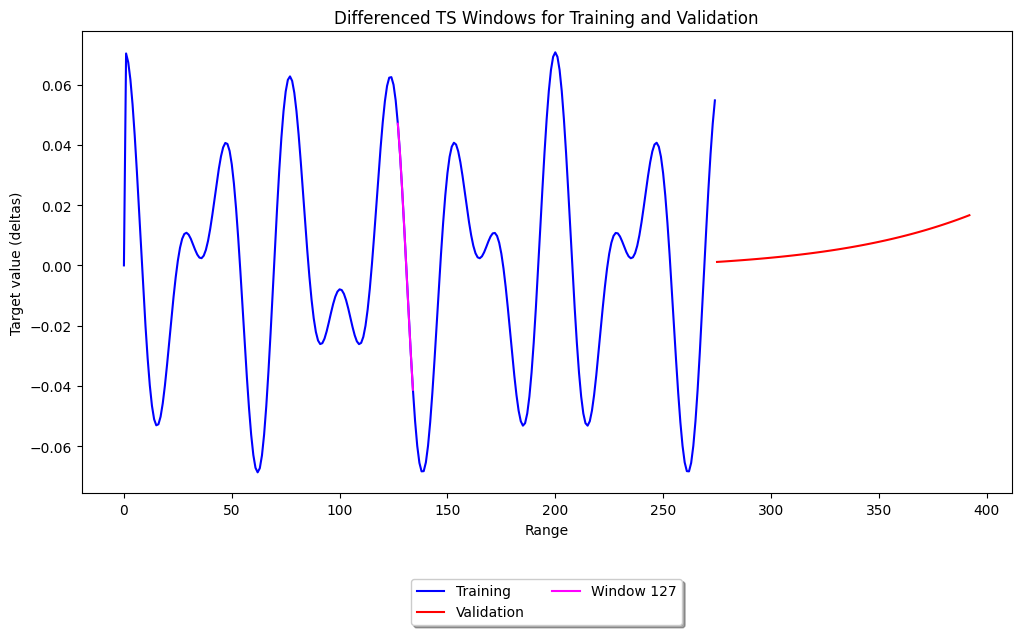


Sample Windows:

f([0,...,7]) ->
 [0.0, 0.07, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02]
f([1,...,8]) ->
 [0.07, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
f([2,...,9]) ->
 [0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, -0.01]
f([3,...,10]) ->
 [0.06, 0.05, 0.04, 0.03, 0.02, 0.01, -0.01, -0.02]
f([4,...,11]) ->
 [0.05, 0.04, 0.03, 0.02, 0.01, -0.01, -0.02, -0.03]



In [8]:
### Plot source data
def qae_plot_source_data(
    X_train, y_train, X_valid, y_valid,
    add_markers=True,
    label_suffix=['', '', ''],
    xlabel='Range', ylabel='Target value (deltas)',
    title=f'Differenced TS Windows for Training and Validation',
    sel_wind=None):

    # Plot the original time series
    plt.rcParams["figure.figsize"] = (12, 6)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.xlim(lb, ub)

    # Plot target function
    plt.plot([xt[0] for xt in X_train], [y[0] for y in y_train], color='blue', label='Training')
    plt.plot([xv[0] for xv in X_valid], [y[0] for y in y_valid], color='red', label='Validation')
    if sel_wind != None:
        plt.plot(X_train[sel_wind], y_train[sel_wind], color='magenta', label='Window '+str(sel_wind))
    if add_markers:
        plt.plot([xt[0] for xt in X_train], [y[0] for y in y_train], marker='o', color='lightblue', linestyle='None')
        plt.plot([xv[0] for xv in X_valid], [y[0] for y in y_valid], marker='o', color='pink', linestyle='None')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
              ncol=2, fancybox=True, shadow=True)
    plt.show()

qae_plot_source_data(X_train_ts, y_train_ts, X_valid_ts, y_valid_ts, sel_wind=127, add_markers=False)
print(f'\nSample Windows:\n')
for i in range(5):
    print(f'f([{round(X_train_ts[i][0], 2)},...,{round(X_train_ts[i][-1], 2)}]) ->\n {[round(v, 2) for v in y_train_ts[i]]}')
print()

### Utilities

In [9]:
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_state_city, plot_state_paulivec
from qiskit import Aer

In [10]:
# Converts measurements amplitudes a and b in a|0>+b|1> into bloch vector
def convert_amps_to_xyz(a, b):
    x = 2*np.real(a*np.conjugate(b))
    y = 2*np.imag(b*np.conjugate(a))
    z = a*np.conjugate(a)-b*np.conjugate(b)
    return [x, y, z] 

### Angle encoding
Deltas between consecutive time series values have been angle encoded. In the context of a quibit representation (see the Figure), the encoding assumes zero to be encoded as H state, negative values to be rotations up, while positive values as rotations down. This encoding allows cumulative sequence calculations and easy value decoding upong the qubit measurements. Should there be huge voilatility in data, additional scaling has been added to shrink the region of valid angular qubit positions. 

<div>
    <!--img src="attachment:qae_fig2_wide.png" width="1000"-->
    <img src="../images/seq-value-encoding.png" width="300">
</div>

**Figure: Sequence value coding as qubit angular rotations**

In [11]:
### Angle encoding of a TS value relative to the previous value
#   val: value in [-1..+1] range to be encoded
#   optional scaler=np.pi/2: Number scaler 
#   optional err_range=0/0.05: allows range scaling to cater for accumulating errors
#   returns: Encoding of the next value relative to the previous value
def ts_relang_encode_val(val, scaler=np.pi/2, err_range=0):
    return val * scaler * (1 - 2 * err_range)

### Decoding
def ts_relang_decode_val(val, scaler=np.pi/2, err_range=0):
    return val / (scaler * (1 - 2 * err_range))

### Normalises the value to 1 (not required with angle encoding)
def ts_relang_norm_val(next_code):
    norm_code = next_code
    return norm_code

### Print encoding and decoding for testing
def print_ts_relang_encode_val(n):
    val = round(ts_relang_encode_val(n), 3)
    if val == 0:
        print(f'{(n)} -> {val} (π*{0.0})')
    else:
        print(f'{(n)} -> {val} (π/{round(np.pi / val, 3)})')
    
def print_ts_relang_decode_val(n):
    if n == 0:
        print(f'{round(n, 3)} (π*{0.0}) -> {ts_relang_decode_val(n)}')
    else:
        print(f'{round(n, 3)} (π/{round(np.pi / n, 3)}) -> {round(ts_relang_decode_val(n), 3)}')

def print_ts_relang_norm_val(p):
    print(f'{round(p, 3)} -> {round(ts_relang_norm_val(p), 3)}')

### Test
# print('Encoding:')
# print_ts_relang_encode_val(0)
# print_ts_relang_encode_val(0.5)
# print_ts_relang_encode_val(0.7)
# print_ts_relang_encode_val(0.25)
# print_ts_relang_encode_val(1.2) # Out of [0..pi] range
# print_ts_relang_encode_val(-0.7) # Out of [0..pi] range

# print('\nDecoding:')
# print_ts_relang_decode_val(np.pi)
# print_ts_relang_decode_val(0*np.pi)
# print_ts_relang_decode_val(np.pi/4)
# print_ts_relang_decode_val(-np.pi/2)
# print_ts_relang_decode_val(np.pi/8)
# print_ts_relang_decode_val(-0.9*np.pi) # Out of [0..pi] range

# print('\nNormalise Encoding:')
# print_ts_relang_norm_val(1.5*np.pi)
# print_ts_relang_norm_val(-0.5*np.pi)

In [12]:
### Encoding the entire data set
def ts_relang_encode(wind_set, scaler=np.pi):
    encoded_set = []
    for wind_idx in range(wind_set.shape[0]):
        wind = wind_set[wind_idx]
        encoded_wind = []
        for val_idx in range(wind.shape[0]):
            val = wind[val_idx]
            encoded_val = ts_relang_encode_val(val, scaler)
            encoded_wind.append(encoded_val)
        encoded_set.append(encoded_wind)
    org_wind_start = np.array([w[0] for w in wind_set])
    return np.array(encoded_set), org_wind_start

### Encoding the entire data set
def ts_relang_decode(org_wind_start, encoded_wind_set, scaler=np.pi):
    decoded_set = []
    for wind_idx in range(encoded_wind_set.shape[0]):
        wind = encoded_wind_set[wind_idx]
        decoded_wind = []
        for val_idx in range(wind.shape[0]):
            encoded_val = wind[val_idx]
            decoded_val = ts_relang_decode_val(encoded_val, scaler)
            decoded_wind.append(decoded_val)
            prev = decoded_val
        decoded_set.append(decoded_wind)
    return np.array(decoded_set)

### In agle encoding, encoded data is already normalised
def ts_relang_norm(encoded_wind_set):
    return np.array(encoded_wind_set)

### Preparing data for training and testing

In [13]:
y_train_enc, org_train_start = ts_relang_encode(y_train_ts)
y_valid_enc, org_valid_start = ts_relang_encode(y_valid_ts)

### Testing validation windows

# y_train_dec = ts_relang_decode(org_train_start, ts_relang_norm(y_train_enc))
# print('\nTraining windows before encoding:\n', y_train_ts[5:8])
# print('\nTraining windows after encoding:\n', y_train_enc[5:8])
# print('\nTraining windows org start:\n', org_train_start[5:8])
# print('\nTraining windows after decoding:\n', y_train_dec[5:8])

# y_valid_dec = ts_relang_decode(org_valid_start, y_valid_enc)
# print('\nValidation windows before encoding:\n', y_valid_ts[0:8])
# print('\nValidation windows after encoding:\n', y_valid_enc[0:8])
# print('\nValidation windows org start:\n', org_valid_start[0:8])
# print('\nValidation windows after decoding:\n', y_valid_dec[0:8])

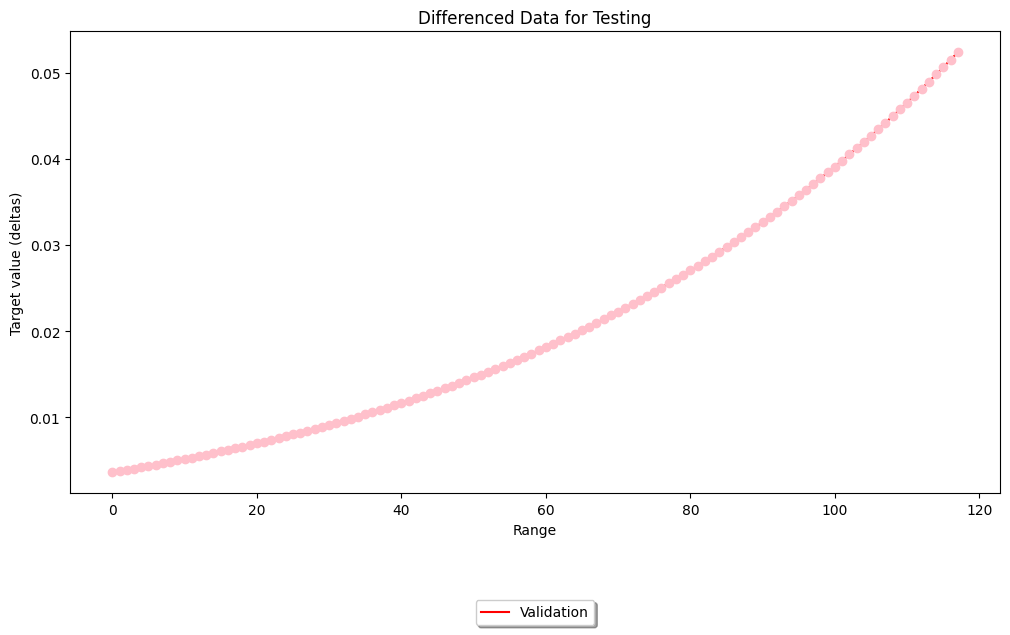

In [14]:
# Plot deltas in the time series
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Differenced Data for Testing")
plt.xlabel("Range")
plt.ylabel("Target value (deltas)")

sel_range=range(len(y_valid_enc))
#sel_range=range(70, 100, 1)
#sel_range=range(10, 40, 1)

plt.plot(list(sel_range), [y[0] for y in y_valid_enc[sel_range]], color='red', label='Validation')
plt.plot(list(sel_range), [y[0] for y in y_valid_enc[sel_range]], marker='o', color='pink', linestyle='None')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
          ncol=2, fancybox=True, shadow=True)
plt.show()

## Building and training a Quantum Autoencoder

In [15]:
### Libraries used in QAE development

import json
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA, NELDER_MEAD
from qiskit.circuit.library import RealAmplitudes, TwoLocal, ZFeatureMap, ZZFeatureMap
from qiskit.quantum_info import Statevector
from qiskit_algorithms.utils import algorithm_globals
from qiskit.visualization import plot_histogram, plot_state_city, plot_state_paulivec
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.circuit import Parameter

### Sequence encoder
The sequence is encoded as a series of angle rotations

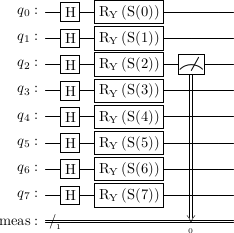


Input parameters for the sequence:  [Parameter(S(0)), Parameter(S(1)), Parameter(S(2)), Parameter(S(3)), Parameter(S(4)), Parameter(S(5)), Parameter(S(6)), Parameter(S(7))]


In [42]:
### Creates a circuit encoding a sequence 
#   - Adds H gates to position each qubit at a "zero" position
#   - Each sequence value y-rotates the qubit state either up (negative) or down (positive)
#   - Use only as many input values as the number of qubits, if not enough provided zero rotations are added
#
#   qubits_no: Number of qubits
#   input_no: Number of values in a sequence
#   optional classreg=False: Flag indicating if a classical register is to be added
#   optional meas_q=None: Indicates the qubit to be measured, active only when classreg=True
#   returns: Circuit encoding a sequence
def sequence_encoder(qubit_no, input_no=None, classreg=False, meas_q=None):

    if input_no == None: 
        input_no = qubit_no
    used_sgates = 0
    label = 'S'

    qr = QuantumRegister(qubit_no, 'q')
    cr = ClassicalRegister(1, 'meas')
    if classreg:
        seq = QuantumCircuit(qr, cr, name='sequence')
    else:
        seq = QuantumCircuit(qr, name='sequence')

    # Data-encoding circuit block, packs different input vars
    for q in range(qubit_no):
        seq.h(q)
        if q > input_no:
            seq.ry(0, q)
        else:
            param_x = Parameter(label+'('+str(used_sgates)+')') if used_sgates < input_no else 0
            seq.ry(param_x, q)
        used_sgates += 1

    if classreg and meas_q != None:
        seq.measure(meas_q, 0)

    return seq, seq.parameters[:]

### Test a sample sequence encoder
sample_seq, inp_params = sequence_encoder(8, 8, classreg=True, meas_q=2)
print('\n')
display(sample_seq.draw(output='latex', style="iqp", fold=False, scale=0.7))
print('\nInput parameters for the sequence: ', inp_params)

**Figure: Example of encoding for a sample sequence window**

### Creation of an ansatz

The selectede ansatz is the Qiskit RealAmplitude ansatz (2-local circuit) - the prepared quantum states will only have real amplitudes, and does not rely on full connectivity between qubits. 

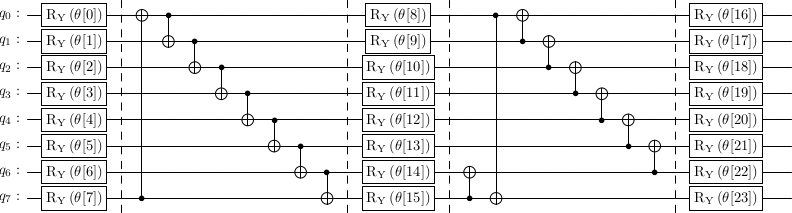


Number of ansatz parameters: 24



In [43]:
### Creates an ansatz to be used for QAE Encoder/Decoder
#   num_latent: size of the latent area
#   num_trash: size of the trash area
#   reps: number of repeating layers
#   ent: type of entanglement layer (linear, reverse_linear, full, circular, sca, pairwise)

# Standard ansatz based Ry and Cx
def ansatz_ra(num_latent, num_trash, reps=3, ent='sca', insert_barriers=False):
    anz = RealAmplitudes(num_latent+num_trash, reps=reps, entanglement=ent, insert_barriers=insert_barriers)
    return anz

# Selected ansatz
def ansatz(num_latent, num_trash, reps=3, ent='sca', insert_barriers=False):
    return ansatz_ra(num_latent, num_trash, reps=reps, ent=ent, insert_barriers=insert_barriers)

### Test the selected ansatz
sample_ansatz = ansatz(6, 2, reps=2, ent='sca', insert_barriers=True) # linear, reverse_linear, full, circular, sca
print('\n')
display(sample_ansatz.decompose().draw("latex", style="iqp", scale=0.7, fold=False))
print(f'\nNumber of ansatz parameters: {len(sample_ansatz.parameters)}\n')

**Figure: Sample QAE ansatz**

### Training Circuit - Sequence + Encoder + Swap Test


Example autoencoder circuit:



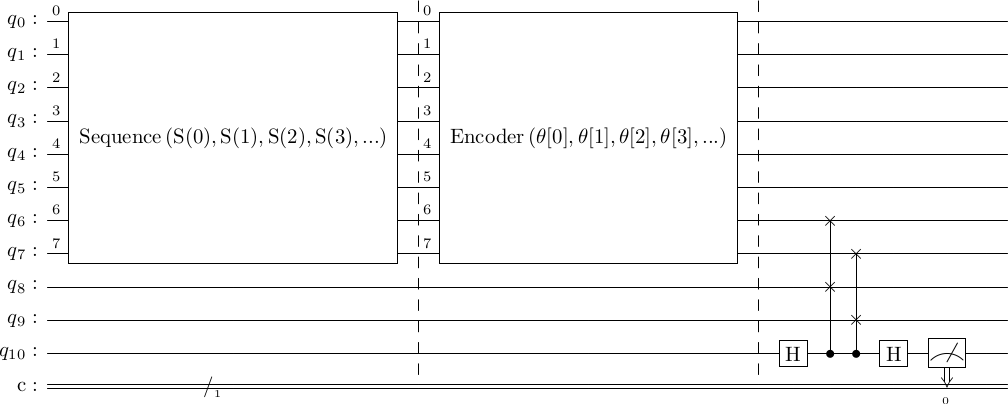

In [44]:
### Building partial QAE for its training

def auto_encoder_circuit(num_latent, num_trash, reps=4, ent='circular'):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    fm_qc, _ = sequence_encoder(num_latent + num_trash)
    fm_qc.name = 'Sequence'
    anz_qc = ansatz(num_latent, num_trash, reps=reps, ent=ent).decompose()
    anz_qc.name = 'Encoder'
    
    circuit = QuantumCircuit(qr, cr)
    circuit.append(fm_qc, qargs=range(num_latent+num_trash))
    circuit.barrier()
    circuit.append(anz_qc, qargs=range(num_latent + num_trash))
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)    
    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit, fm_qc, anz_qc

### Test a training circuit
sample_ae, _, _ = auto_encoder_circuit(6, 2, reps=2, ent='sca')
print('\nExample autoencoder circuit:\n')
display(sample_ae.draw("latex", style="iqp", scale=1))

**Figure: QAE structure for its training (using Encoder and a Swap Test)**<br/>
Again, we can see the swap test being performed on the selected qubits to determine the value of our cost function.

### Testing Circuit - The entire QAE

The full Autoencoder consists of both the Encoder and Decoder, which is simply an inverted Encoder. 
Both the Encoder and Decoder can be initialised using the same parameters obtained from the Encoder (plus swap test) training.
By applying the full QAE circuit to a test dataset, we can then determine the model accuracy.

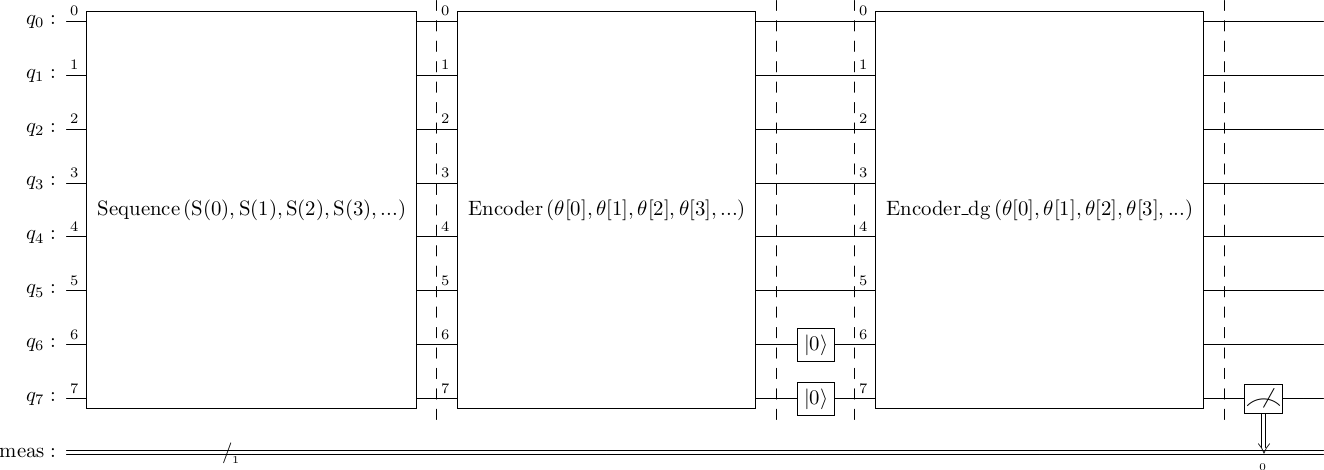


#QAE Input Parameters: 8
#Encoder/Decoder Weights: 24
#QAE Total Weights: 32



In [45]:
### Full QAE for testing the previously trained model

def qae(lat_no, trash_no, reps=3, ent='sca', classreg=False, meas_q=None):

    # Prepare a circuit
    qr = QuantumRegister(lat_no + trash_no, 'q')
    cr = ClassicalRegister(1, 'meas')
    # qae_qc = QuantumCircuit(lat_no + trash_no, 1)
    if classreg:
        qae_qc = QuantumCircuit(qr, cr, name='qae')
    else:
        qae_qc = QuantumCircuit(qr, name='qae')

    # Create all QAE components
    fm_qc, _ = sequence_encoder(lat_no + trash_no)
    fm_qc.name = 'Sequence'
    ansatz_qc = ansatz(lat_no, trash_no, reps=reps, ent=ent)
    ansatz_qc.name = 'Encoder'

    # Create a circuit
    qae_qc.append(fm_qc, qargs=range(lat_no + trash_no))
    qae_qc.barrier()
    qae_qc.append(ansatz_qc, qargs=range(lat_no + trash_no))
    qae_qc.barrier()
    
    for i in range(trash_no):
        qae_qc.reset(lat_no + i)
    
    qae_qc.barrier()
    ansatz_inv_qc = ansatz_qc.inverse()
    qae_qc.append(ansatz_inv_qc, qargs=range(lat_no + trash_no))

    # Add optional measurement
    if classreg and meas_q != None:
        qae_qc.barrier()
        qae_qc.measure(meas_q, 0)

    return qae_qc, fm_qc, ansatz_qc

sample_qae_qc, sample_fm_qc, sample_an_qc = qae(6, 2, reps=2, ent='sca', classreg=True, meas_q=7)

### Show a sample test circuit - the sequence feature map and the ansatz will beused further
print('\n')
display(sample_qae_qc.draw("latex", style="iqp", scale=1))
print('\n#QAE Input Parameters:', len(sample_fm_qc.parameters))
print('#Encoder/Decoder Weights:', len(sample_an_qc.parameters))
print('#QAE Total Weights:', len(sample_qae_qc.parameters))
print()

**Figure: Full QAE capable of mapping input sequence to its output (after Encoder training)**

## Model training

**Sampler** needs to be imported from *qiskit_aer.primitives*.
Unfortunately, *qiskit-aer-gpu 0.12.2* has a bug, which has been fixed 
in the next version *qiskit-aer-gpu 0.13.0*, see notes in the version table.

### Simulator device

In [20]:
### Find what devices are available
from qiskit_aer.backends import AerSimulator
devices = AerSimulator().available_devices()
devices

('CPU', 'GPU')

In [21]:
## Force the CPU
devices = ('CPU')
devices

'CPU'

### Sampler options

In [22]:
### Create a sampler suitable for the device
#   GPU methods: statevector, tensor_network, density_matrix, unitary

from qiskit.primitives import Sampler # For "CPU", ignores device="GPU" option
from qiskit_aer.primitives import Sampler as AerSampler # For device="GPU" option

seed = 2023
algorithm_globals.random_seed = 42

# Use GPU when present, otherwise CPU
if 'GPU' in devices:
    device = 'GPU'
    sampler = AerSampler(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': 1000},
        transpile_options={"seed_transpiler": seed},
    )
else:
    device = 'CPU'
    sampler = Sampler()
    sampler.set_options(method='statevector')
    sampler.set_options(device=device)
    sampler.set_options(seed=seed)
    sampler.options

print(f'Selected device: {device}')

Selected device: CPU


### Cost function
We build our cost function, based on the swap test between the reference and trash space for the digit dataset. To do this, we again use Qiskit's CircuitQNN network and use the same interpret function as we are measuring the probability of getting the final qubit in the $|1\rangle$ state.

In [23]:
from sklearn.utils import shuffle as data_shuffle

# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6) 

class Cost:
    name = "Cost class"
    
    # Initialises the costs
    def __init__(self, train_set, optimizer, init_vals, shuffle=False, shuffle_interv=10):
        self.shuffle = shuffle
        self.shuffle_interv = shuffle_interv
        self.objective_func_vals = []
        self.opt = optimizer
        self.init_vals = init_vals
        self.iter = 0
        self.rand = 2023
        if self.shuffle:
            self.train_set = data_shuffle(train_set, random_state=self.rand)
        else:
            self.train_set = train_set


    ### Reset objective function values
    def reset_objfuncs(self):
        self.objective_func_vals = []

    ### Cost function used in training
    def cost_fun(self, params_values, *args):
        self.iter = self.iter+1
        
        if (self.shuffle) and (self.iter % self.shuffle_interv == 0):
            # print(f'*** Shuffled at iteration {self.iter}')
            self.train_set = data_shuffle(self.train_set, random_state=self.rand)
            
        probabilities = qnn.forward(self.train_set, params_values)
        cost = np.sum(probabilities[:, 1]) / self.train_set.shape[0]
    
        # plotting part
        clear_output(wait=True)
        self.objective_func_vals.append(cost)
        plt.title(f'Cost function value against iteration (Iter# {self.iter})')
        plt.xlabel("Iteration")
        plt.ylabel("Cost function value")
        plt.plot(range(len(self.objective_func_vals)), self.objective_func_vals)
        plt.show()
    
        return cost

    def optimize(self):
        return opt.minimize(fun=self.cost_fun, x0=self.init_vals)


### Performance metrics

In [24]:
### Various metrics calculated between two TS window sets given as dictionaries

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

### Merge a window set given as a dictionary into a list of its entries
def merged_tswind(wind_dict, trim_left=0, trim_right=0):    
    wind_list = []
    sorted_keys = sorted(wind_dict.keys())
    if (trim_left+trim_right) <= len(wind_dict[sorted_keys[0]]):
        for sel_wind in sorted_keys:
            wind = wind_dict[sel_wind]
            wind = wind[trim_left:]
            wind = wind[:-trim_right] if trim_right>0 else wind
            wind_list.extend(wind)
    return wind_list

### Perform RMS on dictionaries
def rms_tswin(wind_exp, wind_pred, trim_left=0, trim_right=0):
    exp = merged_tswind(wind_exp, trim_left=trim_left, trim_right=trim_right)
    pred = merged_tswind(wind_pred, trim_left=trim_left, trim_right=trim_right)
    return np.sqrt(mean_squared_error(exp, pred))    

### Perform MAE on dictionaries
def mae_tswin(wind_exp, wind_pred, trim_left=0, trim_right=0):
    exp = merged_tswind(wind_exp, trim_left=trim_left, trim_right=trim_right)
    pred = merged_tswind(wind_pred, trim_left=trim_left, trim_right=trim_right)
    return mean_absolute_error(exp, pred)    

### Perform MAPE on dictionaries
def mape_tswin(wind_exp, wind_pred, trim_left=0, trim_right=0):
    exp = merged_tswind(wind_exp, trim_left=trim_left, trim_right=trim_right)
    pred = merged_tswind(wind_pred, trim_left=trim_left, trim_right=trim_right)
    return mean_absolute_percentage_error(exp, pred)    

### Calculate R score on dictionaries
def r2_tswin(wind_exp, wind_pred, trim_left=0, trim_right=0):
    exp = merged_tswind(wind_exp, trim_left=trim_left, trim_right=trim_right)
    pred = merged_tswind(wind_pred, trim_left=trim_left, trim_right=trim_right)
    return r2_score(exp, pred)    

### Sample data
tsw_exp = {}
tsw_exp[2] = [2, 5, 9, 20, 21]
tsw_exp[5] = [5, 8, 9, 10, 11]
tsw_exp[1] = [1, 2, 3, 4, 5]
tsw_exp[3] = [3, 9, 11, 12, 13]

tsw_pred = {}
tsw_pred[2] = [3, 6, 10, 21, 20]
tsw_pred[5] = [6, 9, 10, 11, 12]
tsw_pred[1] = [2, 3, 4, 5, 4]
tsw_pred[3] = [4, 10, 12, 13, 14]

### Testing merge_tswind
# print('\nTesting merged_tswind')
# print(f'\tOriginal dict: {tsw_exp}')
# print(f'\tMerged dict: {merged_tswind(tsw_exp)}')
# print(f'\tMerged trim 2 left: {merged_tswind(tsw_exp, trim_left=2)}')
# print(f'\tMerged trim 1 right: {merged_tswind(tsw_exp, trim_right=1)}')
# print(f'\tMerged trim 2 left and 1 right: {merged_tswind(tsw_exp, trim_left=2, trim_right=1)}')
# print(f'\tMerged trim 3 left and 3 right: {merged_tswind(tsw_exp, trim_left=3, trim_right=3)}')
# print()

### Testing metrics
# print('\nTesting metrics')
# print(f'\tRMS: {rms_tswin(tsw_exp, tsw_pred)}')
# print(f'\tMAE: {mae_tswin(tsw_exp, tsw_pred)}')
# print(f'\tMAPE: {mape_tswin(tsw_exp, tsw_pred)}')
# print(f'\tR2: {r2_tswin(tsw_exp, tsw_pred)}')

### Constants guiding QAE training

In [25]:
reps=2
ent='sca' # linear, reverse_linear, full, circular, sca, pairwise
num_qubits = wind_size
num_trash = 2
num_latent = num_qubits-num_trash
epochs = 200 

### Defining structures of training and testing models and their components
*Note that the trainnig model will be used further, however, the testting model is used only as a reference for its structural properties. The actual testing models will be generated dynamically.*

In [26]:
# Models structures
train_ae_qc, _, _ = auto_encoder_circuit(num_latent, num_trash, reps=reps, ent=ent)
test_qae_qc, fm_qc, an_qc = qae(num_latent, num_trash, reps=reps, ent=ent, classreg=False)
print(f'Encoder characteristics: \n'+
      f'\tinputs={num_latent+num_trash}\n'+
      f'\ttrash layer={num_trash}\n'+
      f'\tlatent layer={num_latent}\n'+
      f'\ttraining qubits={num_latent + 2 * num_trash + 1}\n'+
      f'\ttesting qubits={num_trash+num_latent}\n'+
      f'\treps={reps}\n'+
      f'\tent={ent}\n'+
      f'\tnum_params={len(an_qc.parameters)}\n\n'+
      f'\tsamples={y_train_enc.shape[0]}\n'+
      f'\tdevice={device}\n'+
      f'\tepochs={epochs}\n'
     )

Encoder characteristics: 
	inputs=8
	trash layer=2
	latent layer=6
	training qubits=11
	testing qubits=8
	reps=2
	ent=sca
	num_params=24

	samples=275
	device=CPU
	epochs=200



### File names to be used for saving results
Files to store modelinitialisation parameters, original input data, measured input data, QAE recovered data

In [27]:
# File names
SAVE_PATH = 'results'
init_file_name = f'qae_angle_lat{num_latent}_tr{num_trash}_reps{reps}_{ent}_p{len(an_qc.parameters)}_init.json'
inorg_file_name = f'qae_angle_lat{num_latent}_tr{num_trash}_reps{reps}_{ent}_p{len(an_qc.parameters)}_org.json'
inmeas_file_name = f'qae_angle_lat{num_latent}_tr{num_trash}_reps{reps}_{ent}_p{len(an_qc.parameters)}_inm.json'
outrec_file_name = f'qae_angle_lat{num_latent}_tr{num_trash}_reps{reps}_{ent}_p{len(an_qc.parameters)}_out.json'

### Setting the initial point
Since model training may take a long time we have already pre-trained the model for some iterations and saved the pre-trained weights. We'll continue training from that point by setting `initial_point` to a vector of pre-trained weights.

In [28]:
saved_starting_point = False

if saved_starting_point:
    ### Using previously saved init point
    print(f'Using previously saved init parameters from file "{init_file_name}"')

    try:
        f = open(init_file_name, 'r')
    except OSError:
        print(f'Could not open/read file: {init_file_name}')
        sys.exit()
    with f:
        initial_point = json.load(f)
else:
    ### Using a random init point
    print(f'Random init parameters to be saved to file "{init_file_name}"')
    initial_point = algorithm_globals.random.random(an_qc.num_parameters)

Random init parameters to be saved to file "qae_angle_lat6_tr2_reps2_sca_p24_init.json"


By minimizing this cost function, we can thus determine the required parameters to compress our noisy images. Let's see if we can encode our images! 

### QAE training

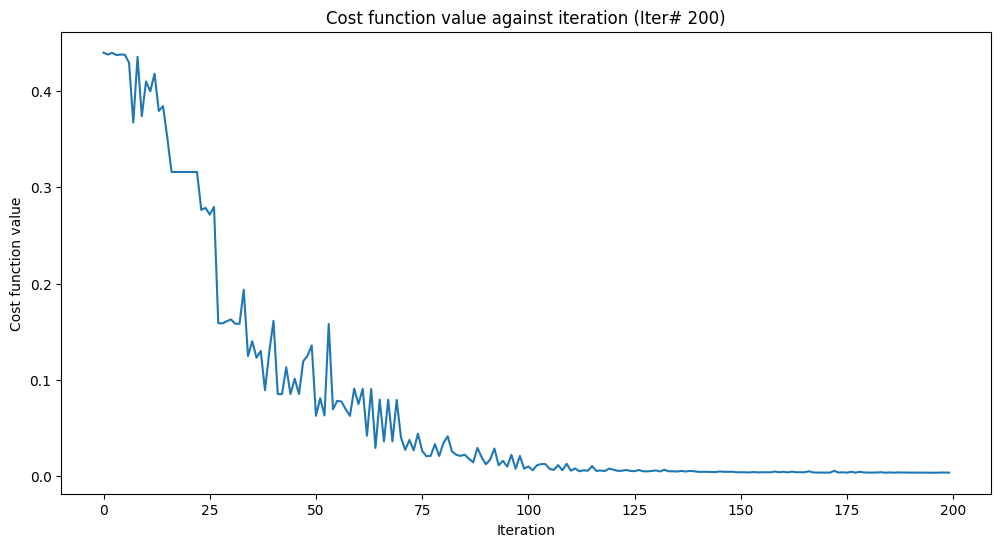

CPU Fit (275 samples, 2 reps, "sca" ent, 6+2 qubits, 24 params, 200 epochs): 0.00364 min cost, 313.68 sec


In [29]:
training_required = True

def identity_interpret(x):
    return x

first_only = lambda x: x % 2

if training_required:
    
    print('Training initiated, optimum parameters will be calculated')
    
    qnn = SamplerQNN(
        circuit=train_ae_qc,
        input_params=fm_qc.parameters,
        weight_params=an_qc.parameters,
        interpret=identity_interpret,
        output_shape=2,
        sampler=sampler
    )
    
    start = time.time()
    
    opt = COBYLA(maxiter=epochs)
    cost_func_tswind = Cost(y_train_enc, opt, initial_point, shuffle=True)
    opt_result = cost_func_tswind.optimize()
    optimum_parameters = opt_result.x
    minimum_cost = opt_result.fun
    elapsed = time.time() - start

    # Print run statistics
    print(f'{device} Fit ('+
          f'{y_train_enc.shape[0]} samples, '+
          f'{reps} reps, '+
          f'"{ent}" ent, '+
          f'{num_latent}+{num_trash} qubits, '+
          f'{len(an_qc.parameters)} params, '+
          f'{epochs} epochs): '+
          f'{round(minimum_cost, 5)} min cost, '+
          f'{elapsed:0.2f} sec')

elif saved_starting_point:
    optimum_parameters = initial_point
    print('Training skipped, previously saved optimum parameters will be used here')
else:
    optimum_parameters = initial_point
    print('Training skipped, optimum parameters were generated randomly')    

## Model testing
Note that all components of a test circuit will be built in the testing process

In [30]:
### Select a backend

backend = Aer.get_backend('aer_simulator_statevector')
# backend = Aer.get_backend('aer_simulator')

### Measuring the state of a single qubit in a circuit (in terms of its y angle)
Recall that the value returned is in relation to the H state, which is zero,<br/>
with rotations to the left interpretaed as negative values, and rotatations to the right as positive values.

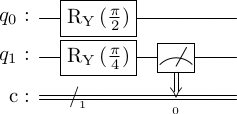

-0.25

In [31]:
### Runs a circuit with a single qubit measured and returns its angular position
#   Recall the figure explaining encoding

def single_qubit_angle_meas(qc, backend, shots=10000):
    job = backend.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    
    counts0 = counts['0'] if '0' in counts.keys() else 0
    counts1 = counts['1'] if '1' in counts.keys() else 0
    p0 = counts0/(counts0+counts1)
    p1 = counts1/(counts0+counts1)
    amp0 = np.sqrt(p0)
    amp1 = np.sqrt(p1)

    meas_angle = 2*np.arccos(amp0)-np.pi/2
    return meas_angle

# Test
qc = QuantumCircuit(2, 1)
qc.ry(np.pi/2, 0)
qc.ry(np.pi/4, 1)
qc.measure(1, 0)
print()
display(qc.draw("latex", style="iqp", scale=1))
angle = single_qubit_angle_meas(qc, backend)
round(angle / np.pi, 2)

### QAE calculation and analysis of the selected TS windows

In [32]:
### Select a collection of windows to test

# sel_wind_set = list(range(30))
# sel_wind_set = [1, 2, 3, 4, 5, 10, 20, 21, 22, 23, 30]
# sel_wind_set = [*range(0, 10)]+[*range(30, 50, 2)]+[*range(60, 75, 2)]
# sel_wind_set = [*range(0, y_valid_enc.shape[0], 3)]
sel_wind_set = [*range(50, 100, 2)]

print(f'Selected {len(sel_wind_set)} windows to process')

Selected 25 windows to process


In [33]:
### Generation of QAE results for the selected windows

### Analyses a sample of windows, QAE(in) -> recons
### winds: a list/array of TS windows
### sel_wind_set: a list of the selected windows indeces
### returns: dictionaries of a subset of original, measured, and reconstructured windows
###          the keys correspond to windows sequence position in a TS

def qae_analyse_sample(winds, sel_wind_set):
    print(f'Processed windows: ', end=' ')

    in_org_set = {}
    in_meas_set = {}
    out_reconstr_set = {}

    for wind_idx in range(len(sel_wind_set)):
    
        sel_wind = sel_wind_set[wind_idx]
        wind = winds[sel_wind]
    
        ### Find the QAE input window state vector representation (as measured)
        org_meas = []
        for meas_q in range(len(wind)):
            org_qc, _ = sequence_encoder(num_latent + num_trash, wind_size, classreg=True, meas_q=meas_q)
            org_qc = org_qc.assign_parameters(wind)
            meas_angle = single_qubit_angle_meas(org_qc, backend, shots=10000)
            org_meas.append(meas_angle)
    
        ### Find the QAE resulting window state vector representation
        out_meas = []
        for meas_q in range(len(wind)):
            param_values = np.concatenate((wind, optimum_parameters))
    
            out_qc, _, _ = qae(num_latent, num_trash, reps=reps, ent=ent, classreg=True, meas_q=meas_q)     
            out_qc = out_qc.assign_parameters(param_values)
            out_qc = out_qc.decompose().decompose()
            meas_angle = single_qubit_angle_meas(out_qc, backend, shots=10000)
            out_meas.append(meas_angle)
    
        ### Add window results
        in_org_set[sel_wind] = list(wind)
        in_meas_set[sel_wind] = org_meas
        out_reconstr_set[sel_wind] = out_meas    
    
        print(f'{sel_wind}', end=' ')
    
    print('End\n')
    return in_org_set, in_meas_set, out_reconstr_set

load_qae_results = False

if load_qae_results:

    ### Loading previously saved original window data, measured input and reconstructed data

    try:
        inorg_file = open(inorg_file_name, 'r')
        inmeas_file = open(inmeas_file_name, 'r')
        outrec_file = open(outrec_file_name, 'r')
    except OSError:
        print(f'Could not open/read results files')
        sys.exit()
    with inorg_file, inmeas_file, outrec_file:
        in_org_set = json.load(inorg_file)
        in_meas_set = json.load(inmeas_file)
        out_reconstr_set = json.load(outrec_file)

    print(f'Loaded windows: {" ".join(in_org_set.keys())} End')

else:
    
    ### Calculate measured input data (for comparison) and reconstructed input data
    in_org_set, in_meas_set, out_reconstr_set = qae_analyse_sample(y_valid_enc, sel_wind_set)


Processed windows:  50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 End



### Reporting of QAE accuracy
Several model performance metrics can be calculated based on the selection of TS windows.<br/>
In the left column we have metrics comparing QAE inputs with the same but quantum measured inputs.<br/>
In the right column we have metrics comparing QAE inputs with its outputs - this is what we are intereted in.<br/>
The left column is for your reference to see the impact of measurement on the QAE precision.

In [34]:
### Present some statistics on the sample

r2_inorg_incalc = r2_tswin(in_org_set, in_meas_set)
r2_inorg_outrec = r2_tswin(in_org_set, out_reconstr_set)
rms_inorg_incalc = rms_tswin(in_org_set, in_meas_set)
rms_inorg_outrec = rms_tswin(in_org_set, out_reconstr_set)
mae_inorg_incalc = mae_tswin(in_org_set, in_meas_set)
mae_inorg_outrec = mae_tswin(in_org_set, out_reconstr_set)
mape_inorg_incalc = mape_tswin(in_org_set, in_meas_set)
mape_inorg_outrec = mape_tswin(in_org_set, out_reconstr_set)

print('\nPrecision of Results\n')
print(f'\tR2(in_org, in_calc) =\t{np.round(r2_inorg_incalc, 3)}, '+
      f'\tR2(in_org, out_rec) =\t{np.round(r2_inorg_outrec, 3)}')
print(f'\tRMS(in_org, in_calc) =\t{np.round(rms_inorg_incalc, 3)}, '+
      f'\tRMS(in_org, out_rec) =\t{np.round(rms_inorg_outrec, 3)}')
print(f'\tMAE(in_org, in_calc) =\t{np.round(mae_inorg_incalc, 3)}, '+
      f'\tMAE(in_org, out_rec) =\t{np.round(mae_inorg_outrec, 3)}')
print(f'\tMAPE(in_org, in_calc) =\t{np.round(mape_inorg_incalc, 3)}, '+
      f'\tMAPE(in_org, out_rec) =\t{np.round(mape_inorg_outrec, 3)}\n')


Precision of Results

	R2(in_org, in_calc) =	-0.965, 	R2(in_org, out_rec) =	-11.302
	RMS(in_org, in_calc) =	0.01, 	RMS(in_org, out_rec) =	0.026
	MAE(in_org, in_calc) =	0.009, 	MAE(in_org, out_rec) =	0.018
	MAPE(in_org, in_calc) =	0.34, 	MAPE(in_org, out_rec) =	0.672



### Ploting sample QAE results
Note the edge distortion, which occurs either at the window's beginning, or more commonly at the end, or both.

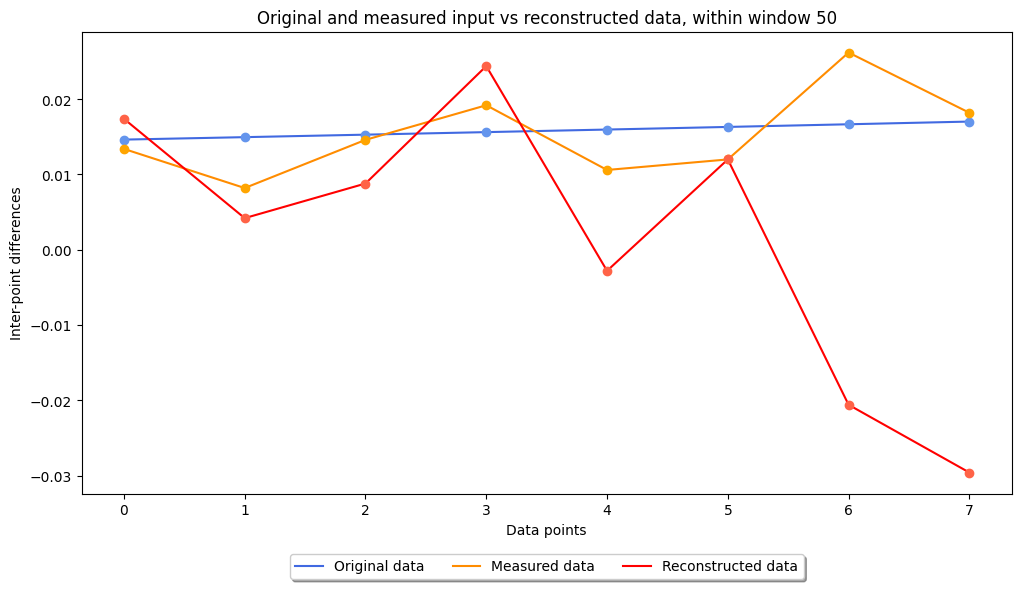

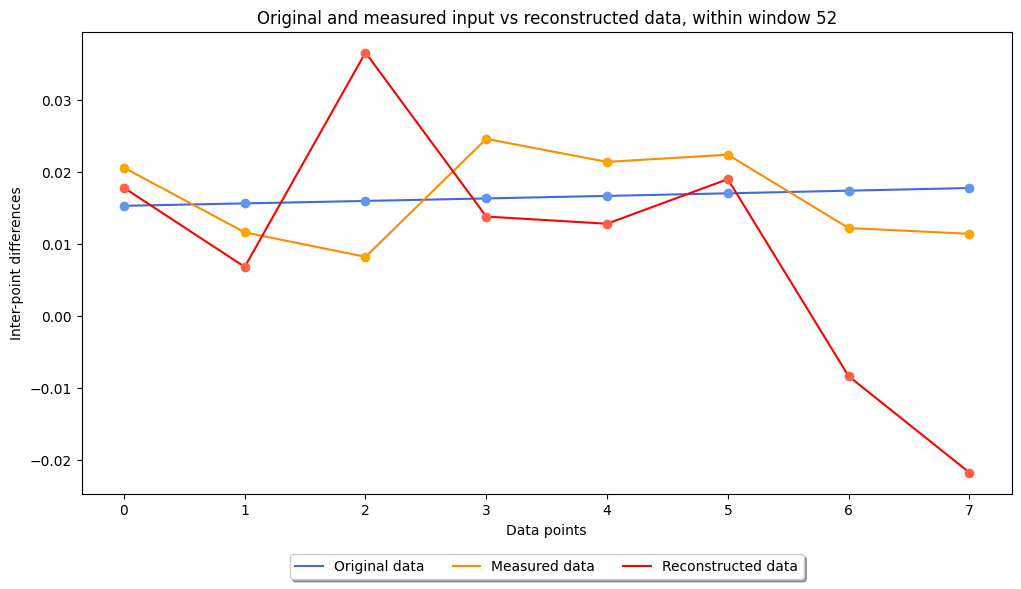

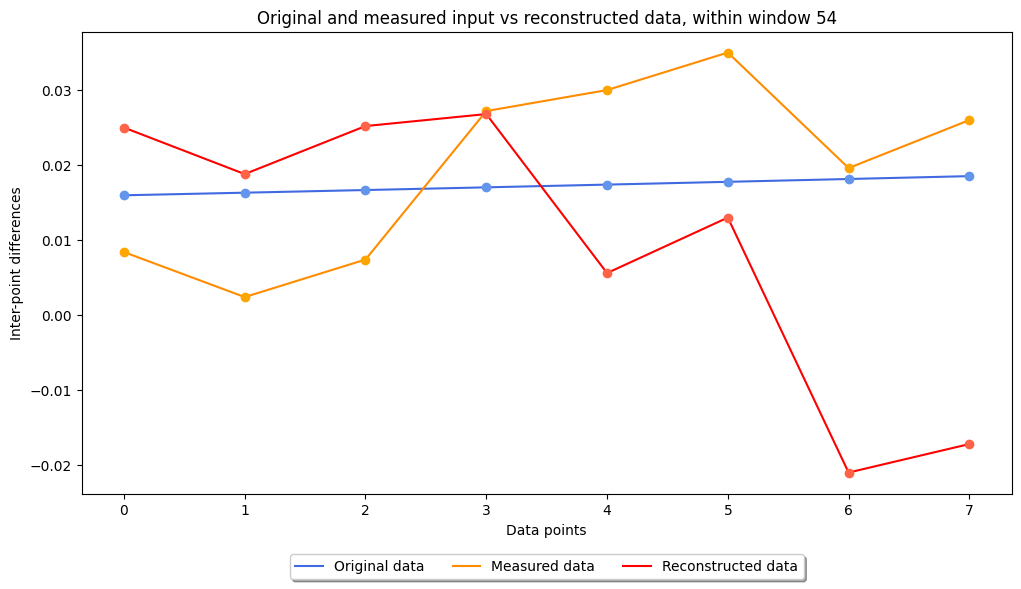

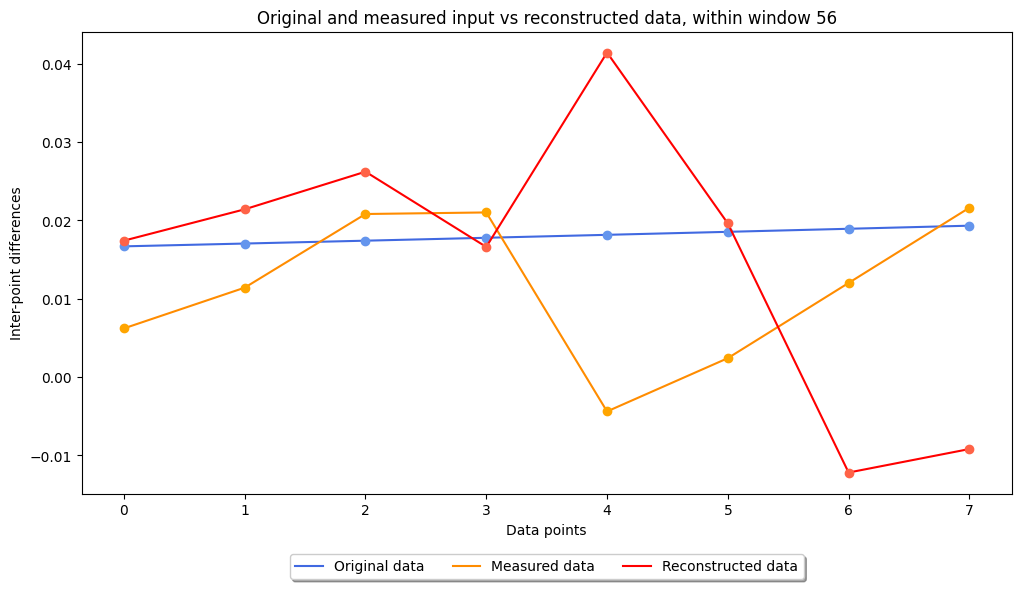

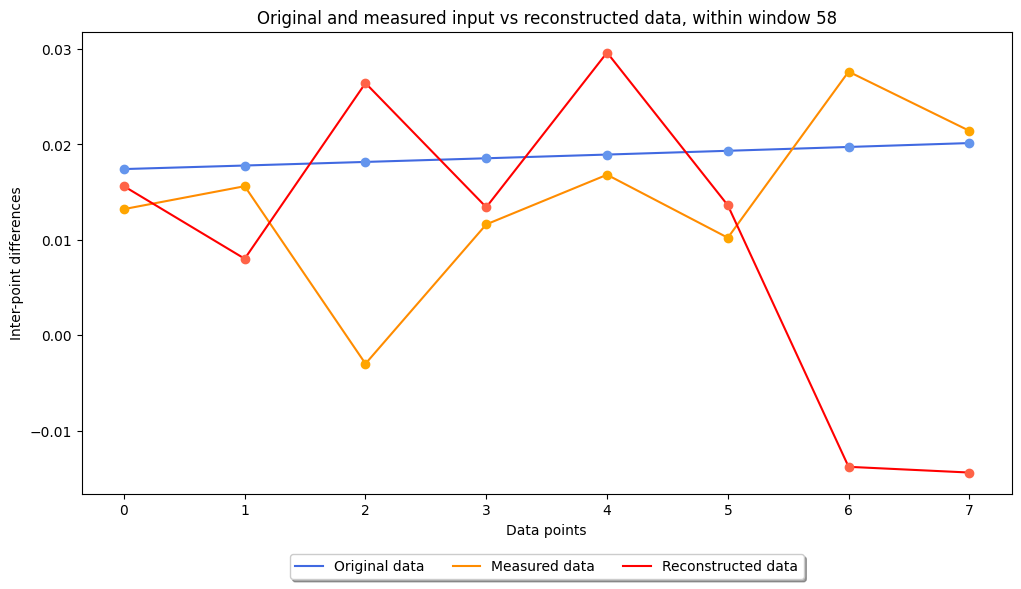

In [35]:
### Plot all the selected windows and their recovered data

def qae_plot_winds(in_org_set, in_meas_set, out_reconstr_set, plot_no=None):
    
    sorted_keys = sorted(in_org_set.keys())
    if plot_no == None:
        plot_no = len(sorted_keys)
        
    for sel_wind in sorted_keys:

        if plot_no == 0:
            break
    
        # Retrieve window data
        print('\n')
        wind = in_org_set[sel_wind]
        org_meas = in_meas_set[sel_wind]
        out_meas = out_reconstr_set[sel_wind]    
        
        # Plot prepared data
        plt.rcParams["figure.figsize"] = (12, 6)
        plt.title(f'Original and measured input vs reconstructed data, within window {sel_wind}')
        plt.xlabel("Data points")
        plt.ylabel("Inter-point differences")
        # plt.xlim(lb, ub)
        
        # Plot target function
        plt.plot([x for x in range(len(wind))], wind, color='royalblue', label='Original data')
        plt.plot([x for x in range(len(wind))], wind, marker='o', color='cornflowerblue', linestyle='None')
        plt.plot([x for x in range(len(wind))], org_meas, color='darkorange', label='Measured data')
        plt.plot([x for x in range(len(wind))], org_meas, marker='o', color='orange', linestyle='None')
        plt.plot([x for x in range(len(wind))], out_meas, color='red', label='Reconstructed data')
        plt.plot([x for x in range(len(wind))], out_meas, marker='o', color='tomato', linestyle='None')
        plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2),
                  ncol=3, fancybox=True, shadow=True)
        plt.show()

        plot_no -= 1
        
    print('\n')

qae_plot_winds(in_org_set, in_meas_set, out_reconstr_set, plot_no=5)

### Accuracy of results after manual removal of edge distortion in a series windows
Based on visual inspection of the QAE results, we can observe that the QAE results are distored at the edges.<br/>
So it is possibe to exclude a few data points from each data window, and hence improve the model accuracy.<br/><br/>
In the left column we have metrics comparing QAE inputs with the same but quantum measured inputs.<br/>
In the right column we have metrics comparing QAE inputs with its outputs - this is what we are intereted in.<br/>
The left column is for your reference to see the impact of measurement on the QAE precision.

In [36]:
### Present some statistics on the sample, after removing the edge distortion
trim_left = 0
trim_right = 3

r2_adj_inorg_incalc = r2_tswin(in_org_set, in_meas_set, trim_left=trim_left, trim_right=trim_right)
r2_adj_inorg_outrec = r2_tswin(in_org_set, out_reconstr_set, trim_left=trim_left, trim_right=trim_right)
rms_adj_inorg_incalc = rms_tswin(in_org_set, in_meas_set, trim_left=trim_left, trim_right=trim_right)
rms_adj_inorg_outrec = rms_tswin(in_org_set, out_reconstr_set, trim_left=trim_left, trim_right=trim_right)
mae_adj_inorg_incalc = mae_tswin(in_org_set, in_meas_set, trim_left=trim_left, trim_right=trim_right)
mae_adj_inorg_outrec = mae_tswin(in_org_set, out_reconstr_set, trim_left=trim_left, trim_right=trim_right)
mape_adj_inorg_incalc = mape_tswin(in_org_set, in_meas_set, trim_left=trim_left, trim_right=trim_right)
mape_adj_inorg_outrec = mape_tswin(in_org_set, out_reconstr_set, trim_left=trim_left, trim_right=trim_right)

print('\nPrecision of results (with trimming)\n')
print(f'\tR2(in_org, in_calc) =\t{np.round(r2_adj_inorg_incalc, 3)}, '+
      f'\tR2(in_org, out_rec) =\t{np.round(r2_adj_inorg_outrec, 3)}')
print(f'\tRMS(in_org, in_calc) =\t{np.round(rms_adj_inorg_incalc, 3)}, '+
      f'\tRMS(in_org, out_rec) =\t{np.round(rms_adj_inorg_outrec, 3)}')
print(f'\tMAE(in_org, in_calc) =\t{np.round(mae_adj_inorg_incalc, 3)}, '+
      f'\tMAE(in_org, out_rec) =\t{np.round(mae_adj_inorg_outrec, 3)}')
print(f'\tMAPE(in_org, in_calc) =\t{np.round(mape_adj_inorg_incalc, 3)}, '+
      f'\tMAPE(in_org, out_rec) =\t{np.round(mape_adj_inorg_outrec, 3)}\n')


Precision of results (with trimming)

	R2(in_org, in_calc) =	-1.092, 	R2(in_org, out_rec) =	-1.033
	RMS(in_org, in_calc) =	0.01, 	RMS(in_org, out_rec) =	0.01
	MAE(in_org, in_calc) =	0.009, 	MAE(in_org, out_rec) =	0.008
	MAPE(in_org, in_calc) =	0.358, 	MAPE(in_org, out_rec) =	0.331



### Saving the starting point and calculated results

In [37]:
### Save the initial point
to_be_saved_starting_point = False

if to_be_saved_starting_point:
    ## Saving the initialisation point
    with open(f'{SAVE_PATH}/{init_file_name}', 'w') as f:
        json.dump(opt_result.x.tolist(), f)
    print(f'Saved optimum parameters as the future starting point in:\n\t{init_file_name}')
else:
    print(f'Parameters not saved') 

Parameters not saved


In [38]:
### Save all calculated data points
to_be_saved_results = False

if to_be_saved_results:
    ## Saving results
    with open(f'{SAVE_PATH}/{inorg_file_name}', 'w') as f:
        json.dump(in_org_set, f)
    with open(f'{SAVE_PATH}/{inmeas_file_name}', 'w') as f:
        json.dump(in_meas_set, f)
    with open(f'{SAVE_PATH}/{outrec_file_name}', 'w') as f:
        json.dump(out_reconstr_set, f)
    print(f'Saved results in:\n\t{inorg_file_name}\n\t{inmeas_file_name}\n\t{outrec_file_name}')
else:
    print(f'Sample windows not saved') 

Sample windows not saved


## Time series integration and plotting
The aim is to merge all windows produced in testing into a single sequence, stored as a dictionary. As depicted in the following figure, the integration procedure needs to average all overalapping windows values (white boxes), while considering the step between windows (which creates gaps between overlapping windows) and their edge trimming (which removes distorted values, indicated as gray boxes). 

<div>
    <!--img src="attachment:wind-integration.png" width="1000"-->
    <img src="../images/wind-integration.png" width="1000">
</div>

**Figure: Windows integration procedure**

### Windows integration

In [39]:
### Integrates QAE results stored in a single set of TS widows into a single sequence
#   Note: When windows overap their average values will be returned
#         When windows are too far apart, separate sub-sequences will be returned
#   wind_set: The selected set of TS windows
#   trim_left: The number of values to be trimmed from the left edge of each window
#   trim_right:  The number of values to be trimmed from the right edge of each window

def qae_winds_integ_1(wind_set, trim_left=0, trim_right=0):

    # Collect all overalapping values into lists attached to individual data points
    vals = {}
    for k in sorted(wind_set.keys()):
        val_list = wind_set[k]
        list_len = len(val_list)
        for i in range(list_len):
            if (i < trim_left) or (i >= list_len - trim_right):
                None # Skip these trimmed values
            else:
                val_idx = k+i
                if val_idx in vals:
                    vals[val_idx].append(val_list[i])
                else:
                    vals[val_idx] = [val_list[i]]

    # Collapse all consecutive values into subsequences
    # All values apart start new subsequences
    seq = {}
    next_key = -3
    prev_key = 0
    for k in sorted(vals.keys()):
        next_key += 1
        if k == next_key:
            seq[prev_key].append(np.average(vals[k]))
        else:
            prev_key = k
            next_key = k
            seq[k] = [np.average(vals[k])]
            
    return seq


### Integrates QAE results stored as TS widows into a single sequence
#   Note: When windows overap their average values will be returned
#         When windows are too far apart, separate sub-sequences will be returned
#   in_org_set: The selected set of original TS windows
#   in_meas_set: The set of measurements of the original values in TS windows
#   out_recons_set: The set of QAE reconstructions for each original TS window
#   trim_left: The number of values to be trimmed from the left edge of each window
#   trim_right:  The number of values to be trimmed from the right edge of each window

def qae_winds_integ(in_org_set, in_meas_set, out_recons_set, trim_left=0, trim_right=0):
    in_org_seq = qae_winds_integ_1(in_org_set, trim_left, trim_right)
    in_meas_seq = qae_winds_integ_1(in_meas_set, trim_left, trim_right)
    out_recons_seq = qae_winds_integ_1(out_reconstr_set, trim_left, trim_right)
    return in_org_seq, in_meas_seq, out_recons_seq

### Test window integration
# in_org_seq, in_meas_seq, out_recons_seq = qae_winds_integ(in_org_set, in_meas_set, out_reconstr_set, trim_left, trim_right)
# [print((k, out_reconstr_set[k])) for k in sorted(out_reconstr_set.keys())]
# print()
# vals = qae_winds_integ_1(out_recons_seq)
# [print((k, vals[k])) for k in sorted(vals.keys())]

### Integrated windows plotting

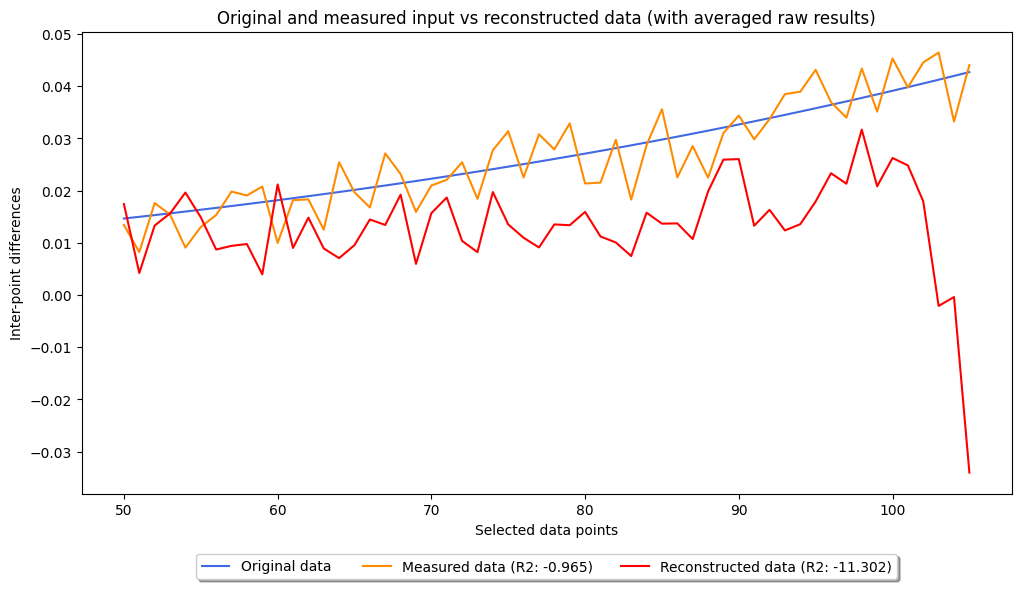

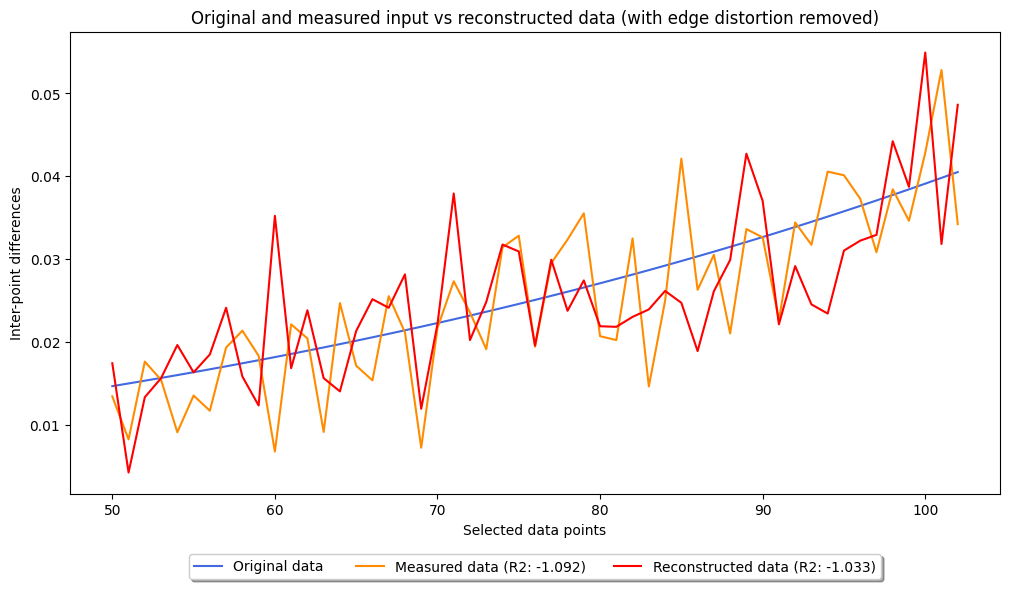

In [40]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

### Returns the x range for the sequence set
def qae_seq_x_range(start, subseq):
    return range(start, start+len(subseq))

### Plots all three sequences (may consist of separate subsets)
def qae_seq_plot(in_org_seq, in_meas_seq, out_recons_seq, 
                 add_markers=False,
                 label_suffix=['', '', ''],
                 xlabel='Selected data points', ylabel='Inter-point differences',
                 title=f'Original and measured input vs reconstructed data'):
    
    sorted_keys = sorted(in_org_seq.keys())
    
    # Plot prepared data
    plt.rcParams["figure.figsize"] = (12, 6)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.xlim(lb, ub)
        
    for sel_wind in sorted_keys:

        org_in = in_org_seq[sel_wind]
        org_meas = in_meas_seq[sel_wind]
        out_meas = out_recons_seq[sel_wind]    
        
        # Plot target function
        plt.plot(qae_seq_x_range(sel_wind, org_in), org_in, color='royalblue')
        if add_markers:
            plt.plot(qae_seq_x_range(sel_wind, org_in), org_in, marker='o', color='cornflowerblue', linestyle='None')
        plt.plot(qae_seq_x_range(sel_wind, org_meas), org_meas, color='darkorange')
        if add_markers:
            plt.plot(qae_seq_x_range(sel_wind, org_meas), org_meas, marker='o', color='orange', linestyle='None')
        plt.plot(qae_seq_x_range(sel_wind, out_meas), out_meas, color='red')
        if add_markers:
            plt.plot(qae_seq_x_range(sel_wind, out_meas), out_meas, marker='o', color='tomato', linestyle='None')
        
    # access legend objects automatically created from data
    handles, labels = plt.gca().get_legend_handles_labels()
    
    # create manual symbols for legend
    line_org = Line2D([0], [0], label=f'Original data {label_suffix[0]}', color='royalblue')
    line_meas = Line2D([0], [0], label=f'Measured data {label_suffix[1]}', color='darkorange')
    line_recon = Line2D([0], [0], label=f'Reconstructed data {label_suffix[2]}', color='red')
    
    # add manual symbols to auto legend
    handles.extend([line_org, line_meas, line_recon])
    
    # plt.legend(handles=handles)    
    plt.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.2),
               ncol=3, fancybox=True, shadow=True)
    plt.show()

    print('\n')
    return
    
### Test integrated window plotting

# Plot all raw results
in_org_seq, in_meas_seq, out_recons_seq = qae_winds_integ(in_org_set, in_meas_set, out_reconstr_set)
qae_seq_plot(in_org_seq, in_meas_seq, out_recons_seq, title=f'Original and measured input vs reconstructed data (with averaged raw results)',
             label_suffix=[f'', f'(R2: {np.round(r2_inorg_incalc, 3)})', f'(R2: {np.round(r2_inorg_outrec, 3)})'])

# Plot all results with distortion trimming
in_org_seq, in_meas_seq, out_recons_seq = qae_winds_integ(in_org_set, in_meas_set, out_reconstr_set, trim_left, trim_right)
qae_seq_plot(in_org_seq, in_meas_seq, out_recons_seq, title=f'Original and measured input vs reconstructed data (with edge distortion removed)',
             label_suffix=[f'', f'(R2: {np.round(r2_adj_inorg_incalc, 3)})', f'(R2: {np.round(r2_adj_inorg_outrec, 3)})'])

## References

1. A wikipedia page on Autoencoder: https://en.wikipedia.org/wiki/Autoencoder

2. Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. "Quantum autoencoders for efficient compression of quantum data." Quantum Science and Technology 2.4 (2017): 045001.

3. Swap Test Algorithm: https://en.wikipedia.org/wiki/Swap_test

4. Bravo-Prieto, Carlos, "Quantum autoencoders with enhanced data encoding." Machine Learning: Science and Technology, 2, May 2021

## Performance Statistics
The format of the presented statistics was evolving over time. In the current edition, which is most evident in the reporting for the experiments running on the "furies-vengence" machine, the reported details include:
- device: Device used to accelerate computation (GPU/CPU)
- samples: Number of samples used in training (numeric)
- reps: Number of repeated blocks in ansatz (numeric)
- ent: Entaglement type (linear, reverse_linear, full, circular, sca, pairwise)
- qubits l+t: Number of core ansatz qubits used in QAE testing (numeric latent + trash qubits)
- params: Number of trainable parameters (numeric)
- epoch: Number of training iterations (numeric)
- min cost: Minimum cost achieved in circuit optimisation (numeric)
- sec: Elapsed time in seconds used in circuit training (numeric)
- R2: R squared providing goodness of fit between the TS window and its reconstruction (0..1)
- Trim l+r: R2 measure between windows trimmed to deal with edge distortion (numeric left + right)
- comment: Additional remark on the experiment's success (e.g. "Promissing" or "Disappointing")
- colour: Colour siginfying the "goodness" of selected experiment's controls (blue=great, red=terrible, magenta=note this, black=FYI)

***furies-vengence: ASUS 64Gb RAM***
- CPU Intel i9, 24 cores, 32 threads, 2.2-3.0-4.3-5.4GHz
- GPU NVIDIA GTX 4090, 16384 CUDA Cores, 24 Gb RAM, CUDA V12.3, NVIDIA Driver 545.29.06

GPU Fit (275 samples, 4 reps, "sca" ent, 6+2 qubits, 40 params, 500 epochs): **0.0076 min cost, 180.64 sec**<br/>
CPU Fit (275 samples, 3 reps, "sca" ent, 6+2 qubits, 32 params, 300 epochs): **0.00529 min cost, 270.89 sec**<br/>
<font color="blue">GPU Fit (275 samples, 2 reps, "sca" ent, 6+2 qubits, 24 params, 300 epochs):</font> **0.00301 min cost, 98.32 sec** (R2=0.815, Trim 0+2 R2=0.984, Promising)<br/>
<font color="blue">GPU Fit (275 samples, 2 reps, "sca" ent, 6+2 qubits, 24 params, 200 epochs):</font> **0.00305 min cost, 65.55 sec** (R2=0.838, Trim 0+2 R2=0.986, Promising)<br/>
<font color="magenta">CPU Fit (275 samples, 2 reps, "sca" ent, 6+2 qubits, 24 params, 200 epochs):</font> **0.00379 min cost, 146.40 sec** (R2=0.785, Trim 0+2 R2=0.976, CPU is 0.45 of GPU speed)<br/>
GPU Fit (275 samples, 2 reps, "linear" ent, 6+2 qubits, 24 params, 200 epochs): **0.00884 min cost, 65.01 sec** (R2=404, Trim R2=NA)<br/>
GPU Fit (275 samples, 2 reps, "circular" ent, 6+2 qubits, 24 params, 200 epochs): **0.014 min cost, 64.83 sec** (R2=-0.303, Trim R2=NA)<br/>
GPU Fit (275 samples, 2 reps, "pairwise" ent, 6+2 qubits, 24 params, 200 epochs): **0.00629 min cost, 54.41 sec** (R2=0.509, Trim 0+4 R2=0.986)<br/>
GPU Fit (275 samples, 2 reps, "full" ent, 6+2 qubits, 24 params, 200 epochs): **0.00556 min cost, 68.24 sec** (R2=0.716, Trim 0+3 R2=0.971)<br/>
GPU Fit (275 samples, 3 reps, "sca" ent, 6+2 qubits, 32 params, 300 epochs): **0.005 min cost, 101.94 sec** (R2=0.766, Trim 2 R2=0.98, Promising)<br/>
GPU Fit (274 samples, 2 reps, "sca" ent, 8+2 qubits, 30 params, 400 epochs): **0.00459 min cost, 140.45 sec** (R2=0.716, Trim 2 R2=0.76)<br/>
GPU Fit (274 samples, 3 reps, "sca" ent, 8+2 qubits, 40 params, 500 epochs): **0.00621 min cost, 182.33 sec** (R2=0.814, Trim 2 R2=0.872)<br/>
<font color="blue">GPU Fit (274 samples, 4 reps, "sca" ent, 8+2 qubits, 50 params, 600 epochs):</font> **0.0039 min cost, 236.92 sec** (R2=0.745, Trim 1+1 R2=0.975, Promising)<br/>
GPU Fit (274 samples, 4 reps, "sca" ent, 8+2 qubits, 50 params, 400 epochs): **0.00404 min cost, 157.36 sec** (R2=0.715, Trim 1+1 R2=0.971)<br/>
GPU Fit (274 samples, 4 reps, "circular" ent, 8+2 qubits, 50 params, 600 epochs): **0.01182 min cost, 243.13 sec** (R2=0.435, Trim R2=NA)<br/>
GPU Fit (274 samples, 4 reps, "pairwise" ent, 8+2 qubits, 50 params, 600 epochs): **0.00751 min cost, 224.47 sec** (R2=0.629, Trim 0+4 R2=0.857)<br/>


***basilisk: Lenovo 32Gb RAM***
- CPU Intel i7, 4 cores, 8 threads, 2.8GHz - No GPU

CPU Fit (110 samples, 6+2 qubits, 32 params): **0.00744 min cost, 226.05 sec**<br/>
CPU Fit (275 samples, 6+2 qubits, 32 params, 400 epochs): **0.00512 min cost, 797.54 sec**<br/>
CPU Fit (275 samples, 6+2 qubits, 32 params, 250 epochs): **0.00623 min cost, 531.32 sec**<br/>
<font color="red">CPU Fit (275 samples, 6+2 qubits, 18 params, 250 epochs):</font> **0.00314 min cost, 308.64 sec** (Bravo-Prieto - terrible)<br/>
<font color="red">CPU Fit (275 samples, 6+2 qubits, 18 params, 125 epochs):</font> **0.00407 min cost, 155.59 sec** (Bravo-Prieto - terrible)<br/>
<font color="red">CPU Fit (275 samples, 6+2 qubits, 18 params, 125 epochs):</font> **0.00684 min cost, 157.55 sec** (Bravo-Prieto - terrible)<br/>
<font color="red">CPU Fit (275 samples, 6+2 qubits, 18 params, 125 epochs):</font> **0.00329 min cost, 154.95 sec** (Bravo-Prieto - terrible)<br/>
CPU Fit (275 samples, 2 reps, "sca" ent, 6+2 qubits, 24 params, 200 epochs): **0.00359 min cost, 284.36 sec** (R2=-6.629, Trim 0+3 R2=-1.783, Test 2)<br/>

***goblin-galore: Tomahawk 64Gb RAM***
- CPU Intel i7, 6 cores, 12 threads, 3.5GHz - 2 GTX NVIDIA 1080 T1 GPUs, CUDA V12.2, NVIDIA Driver 535
- Note that this GPU at 6.1 compute capability is not compatible with Qiskit (cuQuantum requirement: +7 compute capability)

CPU Fit (275 samples, 6+2 qubits, 32 params, 400 epochs): **0.00456 min cost, 695.26 sec**<br/>
CPU Fit (274 samples, 8+2 qubits, 40 params, 400 epochs): **0.00364 min cost, 2430.50 sec** (Promising)<br/>
CPU Fit (274 samples, 6+3 qubits, 45 params, 500 epochs): **0.00907 min cost, 3603.48 sec** (Disappointing)<br/>
CPU Fit (275 samples, 5+3 qubits, 40 params, 300 epochs): **0.02233 min cost, 731.32 sec** (Disappointing)<br/>
CPU Fit (275 samples, 5+3 qubits, 40 params, 300+100 epochs): **0.01913 min cost, 245.12 sec** (Disappointing)<br/>
CPU Fit (275 samples, 6+2 qubits, 24 params, 300 epochs): **0.00334 min cost, 453.17 sec** (Promising)<br/>
CPU Fit (275 samples, 2 reps, "sca" ent, 6+2 qubits, 24 params, 200 epochs): **0.00364 min cost, 309.03 sec** (R2=0.655, Trim 0+2 R2=0.934, Test 1)<br/>
CPU Fit (275 samples, 2 reps, "sca" ent, 6+2 qubits, 24 params, 200 epochs): **0.00364 min cost, 313.68 sec** (R2=-11.302, Trim 0+3 R2=-1.033, Test 2a)<br/>

## Logs

**Qiskit QAE with Unary Encoding**
- V1 Using QAE for anomaly detection (by denoising)
    - V1.1 Tested binary encoding, which misses proximity
    - V2.0 Created an "unary" encoding scheme
    - V2.1 Unary encoding tested with various options, not close
      - Issues noted:
          - Issue 01 (Completed) *Not sure how to interpret the output - cannot be visual*
          - Issue 02 (Completed) *Visual match between input and output not close*
          - **Issue 03** *Noise needs to be injected in training*
          - Issue 04 (Completed) *Training is getting slow, need to use GPU*
          - **Issue 05** *It is worth testing if an increase of the latent or trash layers could improve the result*
      - Action planned:
          - *Add Aer GPU*, *Add noise in training*, *Add convolution*, *Create classical solution to compare*
    - V2.2 Adding GPU plus encoding test
      - Encoding test:
          - Tested amplitude encoding. To improve the QAE we may need to focus on other aspects of the model,
            e.g. incorporation of noise and improvement to the ansatz to ensure neighbourhoods are strongly
            entangled.
      - Several problems installing GPU support, attempt to address **Issue 04**
          - Issue 06 (Completed) *Several problems associated with GPU support*<br/>
          - **Fix 06** *Need to install ML 0.7.1+ and Aer 0.13.2+*<br/>
            ML 0.7.1 standard installation (no need to install from source anymore)<br/>
            Aer 0.13.2 requires CUDA + cuQuantum + cuTensor (Deb)<br/>
            - Note that Aer Sampler has a bug and will not work with RawFeatureVector.
          - **Fix 04** *With GPU the training speed increased ~2 times
    - V2.3 Attempt to move to PuTorch, abandoned for the time being
    - V2.4 Changing to angle encoding - relative with Ry over 2pi
      - Issues noted:
          - Issue 07 (Completed) *Negative numbers not coded properly*</br>
      - Action planned:
          - *Change encoding as relative from H over pi* - with [-1:0] pi/2 negatives towards |0> and [0:+1] pi/2 positives towards |1>
    - V2.5 Completed QAE with angle encoding, lots of fixes
      - Fixes completed:
          - **Fix 07** *Adopted encoding around H state, up negative, down positive*
          - **Fix 02** *Resulting QAE outputs better match the inputs*
          - **Fix 01** *With the new encoding, the output is easy to interpret*
      - Issues noted:
          - *Issue 08* (Partially Completed) *QAE reconstruction has large variance end of windows*, averaging overlapping windows may help
          - **Issue 09** *Need to reconstruct the entire series*, possibly with averaging of overlapping windows
      - Action planned:
          - **Issue 10** *Systematically experiment with:* data sets, window size, step size, trash size, qubit no, ansatz reps and entanglement type
    - V2.6 Testing various QAE configurations
      - Varied the number of qubits (8 was best) and asatz reps (4 was best)
      - Issues noted:
          - Issue 11 (Completed) *Random seed seems to have little effect on results*
          - Issue 12 (Completed) *QAE results tend to be close to zero at the window ends, e.g. 1st and 7th value [0..7]*
          - Issue 13 (Completed) *Related to #12, the first window value should not be zero but the diff with the value from the previous window*<br/>
            Change the order of processing - first create deltas, then split into windows, change TS value encoding and decoding (no need to delta)
    - V2.7 Testing with an older computer Tomahawk, 64Gb RAM, 2 x GeForce GTX 1080 Ti, also testing the enhance encoding of Bravo-Prieto [4]
      - Issues noted:
          - **Issue 14** *GPU failed with error:*<br/>
            Simulation failed and returned the following error message:<br/>
            ERROR:  [Experiment 0] This program was not compiled for SM 61<br/>
            Reason (as provided on Slack), CuQuantum does not support GTX 1080 GPUs (cat.SM 61) - may not be fixable, GPU too old
          - Issue 15 (Completed) *A series of experiments with Bravo-Prieto's algorithm failed to produce any results*
      - Fixes completed:
          - **Fix 15** Bravo-Prieto algorithm could not be reproduced in any form, and with all possible options - it was abandoned*
      - CPU run works well - faster than Lenovo, results are pretty good (as per V2.6)
    - V2.8 Fixed incorrect coding of the first window value
      - Fixes completed:
          - **Fix 11** *Added **seed-simulator** to the backend options for GPU, this may be added for CPU when using AerSampler for CPU*
          - **Fix 12-13** *The first window encoded value is now delta of the first value minus the last value from the previous window*<br/>
            This was achieved by encoding the entire time series first, before splitting it into windows<br/>
            Additional charts were provided to show the original data, encoded sequence, and testing sequence<br/>
            QAE results at the edges of a window are non zero
      - Issues notes:
          - **Issue 16** *Noted high accuracy of results in the middle of windows, however, the edges are distorted* - related to **Issue 08** and **issue 12**.<br/>
            The causes of this phenomenon may be: (1) the ansatz entanglement strategy, (2) position of Swap Test and recovery of the trash space, or (3) the sequential presentation of input.<br/>
            A possible approach would be to shuffle data on input, move the position of the trash to the middle, or to reject the values on edges.<bt/>
            To test this we need to experiments with larger windows
    - V2.9 Tested QAE with windows of size 10 - great results
      - Fixes completed:
          - **Fixed 08** *When testing with widnows of size 8 and 10, the edge inaccuracy persists but shifts*<br/>
            This may be the feature of the approach with Swap Test training
      - Action planned:
        This run was saved and the generated parameters and data will be used to address **Issue 9** (reconstruction of the series)
    - V2.10 Started a cleanup of all code
      - A test was conducted to create a QAE with 5/6 latent and 3 trash qubits. Its results were disappointing. The notebook, however, was copied to the Runs folder.
    - V2.11 Finished cleanup
    - V2.12 Adding precision stats of QAE results - R2, RMS, MAE and MAPE, with optional edge trimming of windows to increase precision
    - V2.13 Extendend the cost function, now part of the class "Cost"<br/>
      - Work conducted:
          - Implemented class "Cost", which allows parameterisation of the function behaviour.
          - **Attempt 16** with the following results:
            - *Implemented shuffling of data durinug training, but there was no impact on the edge distortion*
            - *Tested variety of entanglement options, "sco" was found to be the best, other strategies produced distortions elsewhere and inferior results, so this may still be the culprit*
            - *Position of the trash space (and the Swap Test) seems to coincide with the edge distortion, so it could be its cause - needs a separate experiment*
    - V2.14 Merging all QAE test windows into a single time series (considering windows step and edge trimming)
    - V2.15 Test 1, Test 2, Test 3, ... - See Test Summary notebook

In [41]:
import qiskit.tools.jupyter

# Note that Qiskit Terra and ML were compiled in from sources
%qiskit_version_table

# As this code was derived from Qiskit tutorial retain the following
%qiskit_copyright